# Model Pre-Training

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [22]:
# Import libraries
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = 18

In [13]:
# Add model directory to system path
from __init__ import base_path

# Now you can import your class
from PreTrainer import PreTrainer, validate_data_format

In [14]:
# Configure the PreTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 25
train_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/train'
val_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/val'
model_config_file = '/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/model/configs/default.yaml'

In [15]:
# Validate Train Data
train_invalid_data_path = validate_data_format(train_path)

Total files: 2248
Invalid Files: 0
Valid Files: 2248
Percentage of valid files: 100.0%


In [5]:
# Validate Val Data
val_invalid_data_path = validate_data_format(val_path)

Total files: 565
Invalid Files: 0
Valid Files: 565
Percentage of valid files: 100.0%


## Training

In [7]:
# Trainer Setup
trainer = PreTrainer(
    batch_size=BATCH_SIZE,
    lr=LR,
    epochs=EPOCHS,
    train_path=train_path,
    val_path=val_path,
    model_config_path=model_config_file,
    model_save_path='trained_models'
)

Using device: cuda


In [8]:
# Perform training
train_history, val_history = trainer.train()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.15it/s]


Epoch 1, Loss: 7.279472301687513
Validation Loss: 2.1211024257871838
Saving model at trained_models with validation loss of 2.1211024257871838


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.18it/s]


Epoch 2, Loss: 2.052364030906132
Validation Loss: 1.7486487097210355
Saving model at trained_models with validation loss of 1.7486487097210355


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.35it/s]


Epoch 3, Loss: 1.894802759374891
Validation Loss: 1.7007642322116427
Saving model at trained_models with validation loss of 1.7007642322116427


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.27it/s]


Epoch 4, Loss: 1.8669056636946542
Validation Loss: 1.684251646200816
Saving model at trained_models with validation loss of 1.684251646200816


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.15it/s]


Epoch 5, Loss: 1.8162359748567853
Validation Loss: 1.6206148068110149
Saving model at trained_models with validation loss of 1.6206148068110149


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.26it/s]


Epoch 6, Loss: 1.755381783417293
Validation Loss: 1.5771518217192755
Saving model at trained_models with validation loss of 1.5771518217192755


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.32it/s]


Epoch 7, Loss: 1.708680920941489
Validation Loss: 1.5417010519239638
Saving model at trained_models with validation loss of 1.5417010519239638


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.23it/s]


Epoch 8, Loss: 1.6774065579686845
Validation Loss: 1.5078736808564928
Saving model at trained_models with validation loss of 1.5078736808564928


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.17it/s]


Epoch 9, Loss: 1.6547259041241238
Validation Loss: 1.4924097723431058
Saving model at trained_models with validation loss of 1.4924097723431058


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.20it/s]


Epoch 10, Loss: 1.6537075281143188
Validation Loss: 1.558968014187283


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 11, Loss: 1.6453932966504778
Validation Loss: 1.5134188996420965


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.13it/s]


Epoch 12, Loss: 1.6338136945452009
Validation Loss: 1.4774982068273756
Saving model at trained_models with validation loss of 1.4774982068273756


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:15<00:00,  4.39it/s]


Epoch 13, Loss: 1.6274909853935242
Validation Loss: 1.4812316232257419


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:15<00:00,  4.38it/s]


Epoch 14, Loss: 1.6346548506191798
Validation Loss: 1.517164448897044


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.23it/s]


Epoch 15, Loss: 1.631961567061288
Validation Loss: 1.4944527281655207


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.36it/s]


Epoch 16, Loss: 1.6351066197667803
Validation Loss: 1.519140899181366


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.24it/s]


Epoch 17, Loss: 1.6225665535245624
Validation Loss: 1.4577743477291532
Saving model at trained_models with validation loss of 1.4577743477291532


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.15it/s]


Epoch 18, Loss: 1.5974194237164088
Validation Loss: 1.409165385696623
Saving model at trained_models with validation loss of 1.409165385696623


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.28it/s]


Epoch 19, Loss: 1.5464154703276498
Validation Loss: 1.365188525782691
Saving model at trained_models with validation loss of 1.365188525782691


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:15<00:00,  4.39it/s]


Epoch 20, Loss: 1.49998106104987
Validation Loss: 1.3115909397602081
Saving model at trained_models with validation loss of 1.3115909397602081


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.15it/s]


Epoch 21, Loss: 1.3804311718259539
Validation Loss: 1.2218581504291959
Saving model at trained_models with validation loss of 1.2218581504291959


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.16it/s]


Epoch 22, Loss: 1.2641422356878007
Validation Loss: 1.1045954260561202
Saving model at trained_models with validation loss of 1.1045954260561202


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:17<00:00,  4.11it/s]


Epoch 23, Loss: 1.1980022856167385
Validation Loss: 1.0512117048104603
Saving model at trained_models with validation loss of 1.0512117048104603


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:17<00:00,  3.98it/s]


Epoch 24, Loss: 1.1408896914550237
Validation Loss: 1.0194366110695734
Saving model at trained_models with validation loss of 1.0194366110695734


100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  4.20it/s]


Epoch 25, Loss: 1.1057430122579848
Validation Loss: 0.9989883369869657
Saving model at trained_models with validation loss of 0.9989883369869657


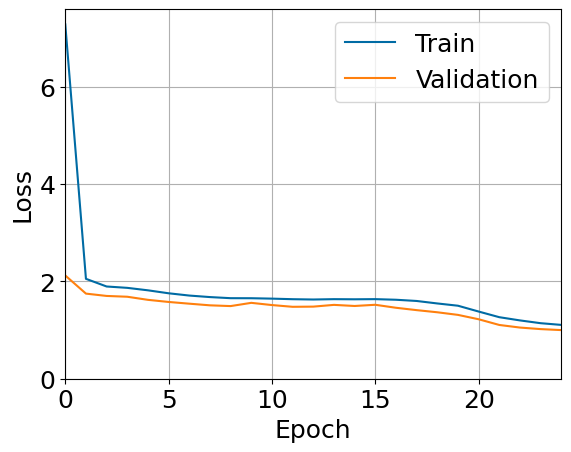

In [23]:
# Plot training & validation history
fig, ax = plt.subplots()
ax.plot(train_history / len(trainer.train_loader), label="Train")
ax.plot(val_history, label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xlim(0, EPOCHS-1)
ax.set_ylim(0)
ax.grid(True)
ax.legend()
plt.show()